# Simple MNIST MLP Classifier with regularization and Hyperparameter search

**Description:** Simple example for Multi Layer Perceptron MNIST Classifier included several regularization 
examples like dropout, learning rate, early stopping <br>
This example has larger layers and more complex training <br>
This example has been modified to optimize batch size <br>
**Dataset:** Classical MNIST dataset <br>
.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages

import tensorflow as tf
import matplotlib.pyplot as plt

import keras_tuner as kt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Model


def Analyze_training(h):
# summarize history for accuracy
# history.history.keys() -> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
   plt.plot(h.history['accuracy'])
   plt.plot(h.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
# summarize history for loss
   plt.plot(h.history['loss'])
   plt.plot(h.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   return

In [2]:
# Data definitions
epochs_num = 20

### Data Preparation

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_train.shape

(60000, 10)

### Hyperparameter Search

In [5]:
# MLP definition & Hyperparameter size
class HyperModel_MNIST(kt.HyperModel):

   def build(self, hp):
    
      ### Optimization of layer sizes
      hlayer1 = hp.Choice('layer1', [8,16,32,128,256,512]) 
      hlayer2 = hp.Int('layer2', min_value=32, max_value=512, step=32)
      hlayer3 = hp.Choice('layer3', [8,16,32,128,256,512]) 
        
      # iput layer
      inputs = layers.Input(shape=(784,))
      # first hidden layer
      x = layers.Dense(hlayer1, activation='relu')(inputs)
      x = layers.Dropout(0.1)(x)
      # second hidden layer
      x = layers.Dense(hlayer2, activation='relu')(x)
      x = layers.Dropout(0.1)(x)
      # third hidden layer
      x = layers.Dense(hlayer3, activation='relu')(x)
      x = layers.Dropout(0.1)(x)
      #Final Layer (Output)
      output = layers.Dense(10, activation='softmax')(x)
    
      model = Model(inputs=[inputs], outputs=output)
      model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])   
      model.summary()
      return model
    
   def fit(self, hp, model, *args, **kwargs):
        return model.fit(
           *args,
          batch_size = hp.Choice('bsize', [8,16,32,128,256,512]),
           **kwargs,
        )
        

In [6]:
from tensorflow.keras.utils import Sequence
import numpy as np

hp = kt.HyperParameters()
hypermodel = HyperModel_MNIST()
model = hypermodel.build(hp)  
#hypermodel.fit(hp, model,np.random.rand(100, 28, 28), np.random.rand(100, 10))
hypermodel.fit(hp, model, x_train, y_train, validation_data=(x_test, y_test) )




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 32)                288       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0     

In [7]:
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=750,
    overwrite = True)
tuner.search(x_train, y_train, epochs=epochs_num, validation_data=(x_test, y_test))

Trial 750 Complete [00h 00m 49s]
val_accuracy: 0.9847000241279602

Best val_accuracy So Far: 0.9861999750137329
Total elapsed time: 06h 29m 09s
INFO:tensorflow:Oracle triggered exit


In [8]:
best_model = tuner.get_best_hyperparameters(num_trials=1)[0]


### Test the best result 

In [9]:
print('best model has layer1:', best_model.get('layer1'), 'layer 2:', best_model.get('layer2'), 'layer 3:', 
       best_model.get('layer3'))
print('the best batch size is: ', best_model.get('bsize'))

best model has layer1: 512 layer 2: 416 layer 3: 128
the best batch size is:  256


In [10]:
hlayer1 = best_model.get('layer1')
hlayer2 = best_model.get('layer2')
hlayer3 = best_model.get('layer3')
bsize = best_model.get('bsize')

In [11]:
def get_MLP():
    
    # iput layer
    inputs = layers.Input(shape=(784,))
    # first hidden layer
    x = layers.Dense(hlayer1, activation='relu')(inputs)
    x = layers.Dropout(0.1)(x)
    # second hidden layer
    x = layers.Dense(hlayer2, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    # third hidden layer
    x = layers.Dense(hlayer3, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    #Final Layer (Output)
    output = layers.Dense(10, activation='softmax')(x)
    
    model = Model(inputs=[inputs], outputs=output)
    
    return model

In [12]:
model = get_MLP()
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(), metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 416)               213408    
                                                                 
 dropout_4 (Dropout)         (None, 416)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               53376     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=bsize,
                    epochs=epochs_num,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/20
235/235 [==============================] - 3s 10ms/step - loss: 0.3098 - accuracy: 0.9042 - val_loss: 0.1090 - val_accuracy: 0.9638
Epoch 2/20
235/235 [==============================] - 3s 11ms/step - loss: 0.1124 - accuracy: 0.9656 - val_loss: 0.1156 - val_accuracy: 0.9669
Epoch 3/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0742 - accuracy: 0.9771 - val_loss: 0.0870 - val_accuracy: 0.9741
Epoch 4/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0577 - accuracy: 0.9823 - val_loss: 0.0912 - val_accuracy: 0.9740
Epoch 5/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0448 - accuracy: 0.9861 - val_loss: 0.0669 - val_accuracy: 0.9817
Epoch 6/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0348 - accuracy: 0.9892 - val_loss: 0.0752 - val_accuracy: 0.9798
Epoch 7/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.1075 - val_accuracy: 0.9729

Test loss: 0.11029605567455292
Test accuracy: 0.9833999872207642
Train accuracy: 0.9991333484649658


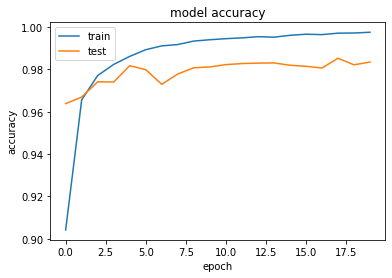

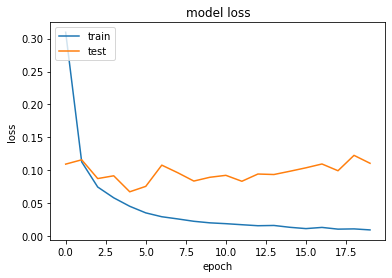

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy:', score[1])

Analyze_training(history)